In [1]:
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.simulators.linear_gaussian import (
    linear_gaussian,
    samples_true_posterior_linear_gaussian_uniform_prior,
)
import torch
from sbi.utils import BoxUniform
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
import sbibm

# What could go wrong (and how to fix it)

## 1. Session: Stay in the SBI bubble: 

- assume valid simulator and prior

<img src="figures/bubble_zacktionman_Flickr.jpg" align="center" alt="beadexample" width="500"/>

# What could go wrong (and how to fix it)

## 2. Session: the full Bayesian workflow

- model building, prior checks -> inference -> posterior checks
<img src="figures/what-if-i-told-you-this-is-not-fully-bayesian.jpg" align="center" alt="beadexample" width="500"/>

# What could go wrong (and how to fix it)

## 1. Session: Stay in the SBI bubble: assume valid simulator and prior

<img src="figures/bubble_zacktionman_Flickr.jpg" align="center" alt="beadexample" width="500"/>

<img src="janfb/figures/bubble_zacktionman_Flickr.jpg" align="right" width="100"/>

## What could go wrong?

- the density estimator is off

- MCMC samples are off (likelihood based methods)


<img src="janfb/figures/bubble_zacktionman_Flickr.jpg" align="right" width="100"/>

## What could be the reason?

1) training not converged "properly" / too little training data
    
2) density estimator lacks flexibility

3) summary statistics (or embedding net) not informative (not discussed today)


<img src="janfb/figures/bubble_zacktionman_Flickr.jpg" align="right" width="100"/>

## How to diagnose it?

- training and inference logs:
    - validaton and training loss convergence
    - more to come... (any ideas?)
    - (MCMC convergence statistics)

- posterior predictive checks
    - sample from posterior and simulate
    - compare to $x_o$
    
- simulation-based calibration

## Problem 1: Training not converged

### Example

In [2]:
# Gaussian simulator
def simulator(theta, scale=0.5):
    # Sample from standard normal, shift with mean.
    return scale * torch.randn(theta.shape) + theta

num_dim = 3
simulator_scale = 0.1
num_samples = 1000
# Uniform prior.
prior = BoxUniform(-5 * torch.ones(num_dim), 5 * torch.ones(num_dim))
x_o = torch.ones(1, num_dim)
# True posterior
true_samples = simulator_scale * torch.randn(num_samples, num_dim) + x_o

In [3]:
# run simulations
num_simulations = 20  # Little training data.
theta = prior.sample((num_simulations,))
x = simulator(theta, scale=simulator_scale)

In [4]:
# run inference
inferer = SNPE(prior, density_estimator="mdn").append_simulations(theta, x)
density_estimator = inferer.train()
posterior = inferer.build_posterior()

/home/ziaee/git/SBI-NMMs/sbi_ve/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


Neural network successfully converged after 423 epochs.


### SBI posterior is off

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 89139.99it/s]


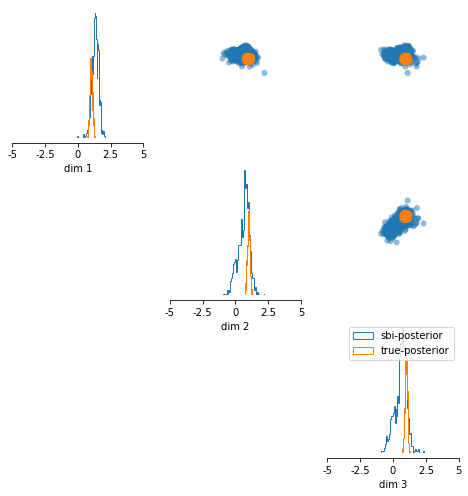

In [5]:
# Draw posterior samples and plot 1 and 2-D marginals.
posterior_samples = posterior.sample((num_samples,), x=x_o)
pairplot([posterior_samples, true_samples], upper="scatter", limits=[[-5, 5]], figsize=(8, 8));
plt.legend(['sbi-posterior' ,'true-posterior']);

### How can we detect this? 

## Diagnostics

### 1) SBI training logs with Tensorboard

- Running tensorboard: in the terminal and in the same folder as this notebook run:

`tensorboard --logdir sbi-logs/`

- This will open a Tensorboard on a localhost, usually http://localhost:6006/

- Demo

## Tensorboard demo

## Diagnostics

### 2) Posterior predictive checks

- General idea: samples from the posterior should reproduce the observed data $x_o$
    - plus simulator noise

- Samples from the posterior plugged into the simulator should cluster around $x_o$


### Example: Posterior predictive checks with true posterior samples

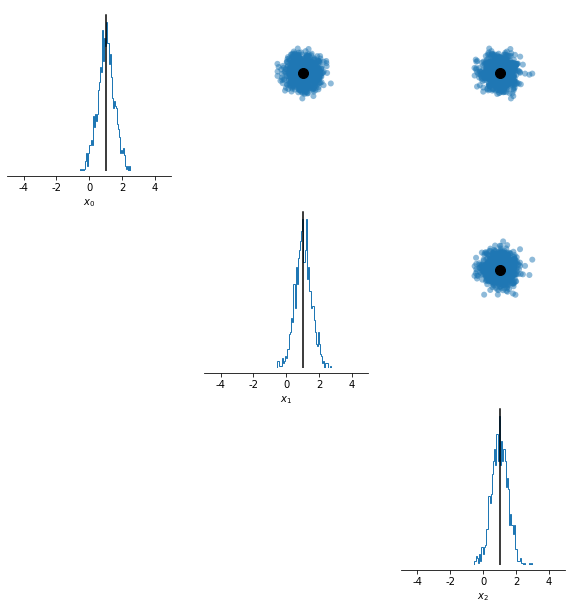

In [6]:
# Simulate with true posterior samples from above.
posterior_predictive_samples = simulator(true_samples)
# Plot on top of x_o
pairplot([posterior_predictive_samples], upper="scatter", points_colors="k", points=x_o, 
         limits=[[-5, 5]], labels=[rf"$x_{ii}$" for ii in range(num_dim)]);

## Practical 1:

1. Run the inference from the previous example.
2. Start Tensorboard and inspect the training logs
    - have a look training log probs and validation log probs
    - what do you observe? did the training converge properly?
3. Run posterior predictive checks with the trained density estimator.
4. Change the training settings and re-run the inference. 
5. Repeat the checks, did it help?

## Problem 2: Lack of flexibility of the density estimator

- SBI offers different types of density estimators: 
    - mixture density networks (of Gaussians) (MDN)
    - normalizing flows

- MDN are fast in training, sampling and evaluation
- Flows are more flexible

## Normalizing flows

<img src="figures/nutshell_Kletr-Shutterstock.jpg" align="left" alt="beadexample" width="130"/> 

- transform a simple base distribution to a complex target distribution

- transforms can be trained with NNs (under certain assumptions)

- concatenating transforms -> powerful (conditional) density estimator

- implemented in `sbi`: 
    - masked autoregressive flows ("MAF")
    - neural spline flows ("NSF")

## Example 2: Inference on the two-moon task

In [7]:
# Load two-moon task from sbi-benchmark package
import sbibm
task = sbibm.get_task("two_moons")
simulator = task.get_simulator()
prior = task.get_prior_dist()

In [8]:
# Simulate
num_simulations = 10000
num_samples = 1000
theta = prior.sample((num_simulations,))
x = simulator(theta)

In [9]:
# run inference with MDN
inferer = SNPE(prior, density_estimator="mdn").append_simulations(theta, x)
density_estimator = inferer.train()
posterior = inferer.build_posterior(density_estimator)

Neural network successfully converged after 55 epochs.


### MDN posterior fails to learn the two moons

In [ ]:
# Draw posterior samples and plot 1 and 2-D marginals.
x_o = task.get_observation(1)
mdn_samples = posterior.sample((num_samples,), x=x_o)
true_samples = task.get_reference_posterior_samples(1)[:num_samples,]
pairplot([mdn_samples, true_samples], upper="scatter", limits=[[-1, 1]], figsize=(7, 7));
plt.legend(["mdn-posterior", "true-posterior"]);

## Practical 2: Changing density estimators

### Tasks
1. Change the density estimator to a flow ([documentation](https://www.mackelab.org/sbi/tutorial/04_density_estimators/)) and train again.
2. Compare to the reference posterior samples (obtained from `sbibm`) using `pairplot`.
3. Compare the different density estimators in terms of posterior predictive samples. 
4. [Optional] The `density_estimator` argument takes a `string` or a function. By passing a `string` you get a density estimator with default settings, by passing a function you can pass your custom density estimator. Have a look at `sbi.utils.get_nn_models` to see how to build such a customised density estimator using the function `posterior_nn(...)` or `likelihood_nn(...)`. [More information](https://www.mackelab.org/sbi/tutorial/04_density_estimators/).

## Problem 3: Leakage in multi-round inference

- **multi-round inference**: in every new round we simulate new training data not from the prior, but from the recent posterior estimate
- this requires some correction and algorithmic sugar (see SNPE [A](https://proceedings.neurips.cc/paper/2016/file/6aca97005c68f1206823815f66102863-Paper.pdf), [B](https://openreview.net/forum?id=Jwgr1P_AioF) and [C](http://proceedings.mlr.press/v97/greenberg19a) papers)
- but can improve data efficiency (see `sbibm` benchmark)

## Problem 3: Leakage in multi-round inference

- SNPE-C is the current method of choice: stable training, ability to use of flows!
- but it comes with a drawback as well:

- for complex problems with bounded priors posterior mass tends to leak outside of the prior bounds
- this can get extreme: with 99,9% of the mass leaking out (warning in `sbi`)

### Solution to problem 3:

- sample posterior with MCMC or classic rejection sampling.
- use likelihood based approaches (SNLE, SNRE) if possible (depends on kind of data).
- use single round inference ;-) 



## Problem 4: MCMC 
- we use MCMC to obtain posterior samples after learning a synthetic likelihood (SNLE) or likelihood ratio (SNRE)
- MCMC is established and reliable but still can get tricky for complex distributions and in high-dimensional spaces


- MCMC exploring high-dimensional spaces:

<img src="https://media.giphy.com/media/jIhNUBuRD2SKA4TrrU/giphy-downsized-large.gif?cid=ecf05e47a7kphsyhpj1g6smvuuc19scoyklxo7cv1krlgwc9&rid=giphy-downsized-large.gif&ct=g" align="right" alt="map"  width="400"/>

- When the prior is bounded MCMC can get stuck in "corners" of the parameter space
- Solution: 
    - run MCMC with parameters transformed to unbounded space 
        - already implemented in `sbi`
    - check MCMC diagnostics (e.g., chain autocorrelation) 
        - not yet implemented


## Practical: Running MCMC

1) Select an inference problem from above (optional: choose a task from the `sbibm` package)

2) Train a density estimator using `SNLE` or `SNRE`. 

3) Generate posterior samples using `posterior_object.sample(...)`

- have a look at the `sbi` API and play around with changing the `mcmc_method` ("slice_np", "slice_np_vectorized", "slice", "hmc") and `mcmc_settings` (`num_chains`, `thin`, `init_strategy`).

In [ ]:
# Your code:
# ...
# posterior_samples = posterior.sample(?)


## MCMC Practical: questions & comments

## Discussion of open questions

- ...

## References

### Further reading
- benchmarking sbi paper: [Lueckmann et al. 2021](http://proceedings.mlr.press/v130/lueckmann21a.html)
- normalizing flows review: [Papamakarios et al. 2019](https://arxiv.org/abs/1912.02762)
- review on MCMC in practice: [Hogg and Foreman-Mackey 2016](https://iopscience.iop.org/article/10.3847/1538-4365/aab76e/meta)

### Figures
- bubble: zacktionman Flickr
- nutshell: Kletr Shutterstock

- GIFs from Giphy
- American woodstock GIF: @Martin_Trapp on Twitter.